# Brain Age Prediction Challenge using diffusion MRI structural connectivity features

# Fully Connected Net só com todos os dados

## Imports

In [2]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact
import time

from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm1d
from torch.nn import Dropout
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import ReLU
from torch.nn import Module
from torch.nn import L1Loss
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torchinfo import summary

from IPython.display import display
from livelossplot import PlotLosses
from functools import reduce

from monai.networks.nets import FullyConnectedNet
from monai.networks.layers.factories import Act
from captum.attr import FeaturePermutation, IntegratedGradients

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

## Constantes

In [3]:
TRAIN_MAT_FILE = 'train_data.mat'
TEST_MAT_FILE = 'test_data.mat'
TRAIN_CSV_FILE = 'train.csv'
TEST_CSV_FILE = 'test.csv'
PATH_TRAIN = 'train_dataset.csv'
PATH_TEST = 'test_dataset.csv'
BATCH_SIZE = 1

## Device Management

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## 1. Preparar os Dados

### 1.1 Leitura das matrizes de conetividade cerebral

In [5]:
train_mat = scipy.io.loadmat(TRAIN_MAT_FILE) 
test_mat = scipy.io.loadmat(TEST_MAT_FILE) 

In [6]:
def get_data_from_mat(train_file,test_file):
    train_mat = scipy.io.loadmat(train_file) 
    test_mat = scipy.io.loadmat(test_file) 
    print(train_mat.keys())
    print(test_mat.keys())
    train_np = np.array(train_mat['train_data']).transpose(2,0,1)
    test_np = np.array(test_mat['test_data']).transpose(2,0,1)
    train_np = np.float32(train_np)
    test_np = np.float32(test_np)
    print(train_np.shape)
    print(test_np.shape)
    return  train_np, test_np

train_data, test_data = get_data_from_mat(TRAIN_MAT_FILE,TEST_MAT_FILE)

dict_keys(['__header__', '__version__', '__globals__', 'train_data'])
dict_keys(['__header__', '__version__', '__globals__', 'test_data'])
(112, 90, 90)
(28, 90, 90)


In [7]:
print(train_data[0])

[[0.         0.         0.13152513 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.13152513 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.28060624]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.28060624 0.         0.        ]]


In [8]:
mat = scipy.io.loadmat(TRAIN_MAT_FILE)
pqr=pd.Series(mat)
pd.DataFrame({'label':pqr.index, 'list':pqr.values})

,label,list
0,__header__,"b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Crea..."
1,__version__,1.0
2,__globals__,[]
3,train_data,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [9]:
print(pqr)

__header__     b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Crea...
__version__                                                  1.0
__globals__                                                   []
train_data     [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
dtype: object


### 1.2 Visualização das matrizes de conetividade cerebral

In [10]:
def visualize(image):  
    #plt.figure("sample", (12, 6))
    #plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")    
    #plt.subplot(1, 2, 2)
    #plt.imshow(image, cmap="gray")
    plt.show()      


#@interact
def show_ds(ds):
    print("ds shape:",ds.shape)
    print("ds max:",np.max(ds))
    print("ds min:",np.min(ds))
    print("ds average:",np.average(ds))
    @interact
    def visualize_set(scan_index=(0,len(ds)-1)):
        #print(scan_index)
        visualize(ds[scan_index,:,:])

show_ds(train_data)

ds shape: (112, 90, 90)
ds max: 1.0
ds min: 0.0
ds average: 0.024116168


interactive(children=(IntSlider(value=55, description='scan_index', max=111), Output()), _dom_classes=('widget…

In [11]:
show_ds(test_data)

ds shape: (28, 90, 90)
ds max: 1.0
ds min: 0.0
ds average: 0.024994023


interactive(children=(IntSlider(value=13, description='scan_index', max=27), Output()), _dom_classes=('widget-…

### 1.3 Conversão das matrizes em arrays 1D e eliminação dos valores a zero

In [12]:
def create_CSV_files(train_mat_file, test_mat_file, train_csv_file, test_csv_file):
    columns = set() #Duplicates Not Allowed :)

    mat = scipy.io.loadmat(train_mat_file)
    m = np.array(mat['train_data'])
    ds = pd.read_csv(train_csv_file)
    ds_c = ds.copy()
    a, b, _ = m.shape
    for i in range(a):
        for j in range(i+1,b): #triangle
            s = f"{i+1} : {j+1}" #Label description
            a = m[i,j] #conection value for all subjects
            tmp_ds = pd.DataFrame(a, columns=[s])
            ds = ds.join(tmp_ds)
            if (False and s in columns) or not (a[0] == a).all():
                ds_c = ds_c.join(tmp_ds)
                columns.add(s)
    ds.to_csv(f'train_dataset_full.csv', index=False)
    ds_c.to_csv(f'train_dataset.csv', index=False)
    
    #process test set
    mat = scipy.io.loadmat(test_mat_file)
    m = np.array(mat['test_data'])
    ds = pd.read_csv(test_csv_file)
    ds_c = ds.copy()
    a, b, _ = m.shape
    for i in range(a):
        for j in range(i+1,b): #triangle
            s = f"{i+1} : {j+1}" #Label description
            a = m[i,j] #conection value value for all subjects
            tmp_ds = pd.DataFrame(a, columns=[s])
            ds = ds.join(tmp_ds)
            if (True and s in columns) or not (a[0] == a).all(): #detect invariant (all equal 0)
                ds_c = ds_c.join(tmp_ds)
                columns.add(s)
    ds.to_csv(f'test_dataset_full.csv', index=False)
    ds_c.to_csv(f'test_dataset.csv', index=False)
    
#create CSV files with full ds for con1d and MLP processing
#create_CSV_files(TRAIN_MAT_FILE, TEST_MAT_FILE, TRAIN_CSV_FILE, TEST_CSV_FILE)

### 1.4 Preparação dos dataloaders

In [13]:
class CSVDataset(Dataset):
    # ler o dataset
    def __init__(self, path_train, path_test):

        # ler o ficheiro csv para um dataframe
        df_train = pd.read_csv(path_train, header=0)
        df_test = pd.read_csv(path_test, header=0)
        
        #Normalização dos valores da matriz por coluna para o treino
        for col in df_train.columns[4:]:
            df_train[col] = (df_train[col] - df_train[col].min()) / (df_train[col].max() - df_train[col].min())  
            
        #Normalização dos valores da matriz por coluna para o teste
        for col in df_test.columns[3:]:
            df_test[col] = (df_test[col] - df_test[col].min()) / (df_test[col].max() - df_test[col].min())

        #Normalização da coluna da education
        df_train["education"] = (df_train["education"] - df_train["education"].min()) / (df_train["education"].max() - df_train["education"].min())    
        df_test["education"] = (df_test["education"] - df_test["education"].min()) / (df_test["education"].max() - df_test["education"].min())    
        
        #creating instance of one-hot-encoder
        encoder = OneHotEncoder(handle_unknown='ignore')

        #perform one-hot encoding on 'sex' column 
        encoder_df_train = pd.DataFrame(encoder.fit_transform(df_train[['sex']]).toarray())
        encoder_df_test = pd.DataFrame(encoder.fit_transform(df_test[['sex']]).toarray())

        #merge one-hot encoded columns back with original DataFrame
        df_train = df_train.join(encoder_df_train)
        df_test = df_test.join(encoder_df_test)
        
        #drop 'sex' column
        df_train.drop('sex', axis=1, inplace=True)
        df_test.drop('sex', axis=1, inplace=True)
        
        # separar os inputs e os outputs
        self.train = df_train.values[:,2:]
        self.label = df_train.values[:,1]
        self.test = df_test.values[:,1:]
            
        #Construção do dicionário
        #Nomes das colunas
        nome_colunas = df_train.columns.values.tolist()
        del nome_colunas[0:2]
        
        self.lista_dic = []
        for vetor in self.train:
            dic = {}
            for i, valor in enumerate(vetor):
                for j, col in enumerate(nome_colunas):
                    if i == j:
                        dic[col] = valor
            self.lista_dic.append(dic)
 
        # garantir que os inputs e labels sejam floats 
        self.train = self.train.astype('float32')
        self.label = self.label.astype('float32')
        self.test = self.test.astype('float32')
        
        #Substituir os nan por 0
        self.test = np.where(np.isnan(self.test), 0.0, self.test)
                             
    # número de casos no dataset
    def __len__(self):
        return len(self.x)
    
    # retornar um caso
    def __getitem_test__(self, idx):
        return [self.test[idx]]
    
    # retornar índices para casos de treino e de teste em formato flat (vetor)
    def get_splits_flat(self):

        train_data = torch.from_numpy(np.array(self.train))
        label = torch.from_numpy(np.array(self.label))
        test = torch.from_numpy(np.array(self.test))
        
        train = torch.utils.data.TensorDataset(train_data, label)
        test = torch.utils.data.TensorDataset(test)
        
        return train, test, train_data, self.lista_dic
    
def prepare_data_loaders(path_train, path_test):
    # criar uma instância do dataset
    dataset = CSVDataset(path_train, path_test)
    
    # calcular split
    train, test, train_data, lista_dic = dataset.get_splits_flat()
    
    #separação de treino e validação
    train_size = int(0.9 * len(train))
    val_size = len(train) - train_size
    train, validation  = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
   
    # preparar data loaders
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True) 
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)

    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all, train_data, lista_dic

# preparar os dados
train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all, train_dados, lista_dic = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

# sanity check
print("Train")
train_data, y = next(iter(train_dl))
print(train_data.shape, y.shape)

print("Val")
train_data, y = next(iter(val_dl))
print(train_data.shape, y.shape)

Train
torch.Size([1, 1205]) torch.Size([1])
Val
torch.Size([1, 1205]) torch.Size([1])


## 2. Visualizar os Dados

In [14]:
def visualize_data(path):
    # criar uma instância do dataset
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset():
     
    print(f"Quantidade de casos de Treino:{len(train_dl_all.dataset)}") 
    train_data, y = next(iter(train_dl_all)) 
    print(f"Shape tensor batch casos treino, input: {train_data.shape}, output: {y.shape}")
    print(f'Valor máximo no treino :{torch.max(train_data)} Valor mínimo:{torch.min(train_data)}')
    print(f'Valor máximo na idade :{torch.max(y)} Valor mínimo:{torch.min(y)}')
    
    print(f"Quantidade de casos de Validação:{len(val_dl_all.dataset)}")
    train_data, y = next(iter(val_dl_all)) 
    print(f"Shape tensor batch casos validação, input: {train_data.shape}, output: {y.shape}")
    print(f'Valor máximo na validação :{torch.max(train_data)} Valor mínimo:{torch.min(train_data)}')
    print(f'Valor máximo na idade :{torch.max(y)} Valor mínimo:{torch.min(y)}')
    
    print(f"Quantidade de casos de Teste:{len(test_dl_all.dataset)}")
    test_data = next(iter(test_dl_all)) 
    print(f"Shape tensor batch casos teste: {test_data[0].shape}")
    print(f'Valor máximo no teste :{torch.max(test_data[0])} Valor mínimo:{torch.min(test_data[0])}')
    
visualize_data(PATH_TRAIN)
visualize_dataset()

,id,age,sex,education,1 : 3,1 : 4,1 : 7,1 : 11,1 : 13,1 : 17,...,83 : 89,84 : 86,84 : 88,84 : 90,85 : 87,85 : 89,86 : 88,86 : 90,87 : 89,88 : 90
0,1,13,1,7,0.131525,0.0,0.271538,0.374434,0.039427,0.076948,...,0.000000,0.028046,0.573282,0.000000,0.239553,0.585254,0.162305,0.585006,0.276153,0.280606
1,2,14,0,8,0.117704,0.0,0.316890,0.359445,0.049076,0.096582,...,0.000000,0.021593,0.576865,0.000000,0.193739,0.631275,0.171084,0.599437,0.320557,0.207478
2,3,15,1,9,0.155806,0.0,0.348072,0.335944,0.045267,0.070500,...,0.000000,0.038532,0.665572,0.000000,0.252137,0.625163,0.202426,0.630374,0.271738,0.246472
3,4,15,1,9,0.145214,0.0,0.310270,0.320711,0.025480,0.073450,...,0.012246,0.028526,0.557595,0.000000,0.228784,0.599624,0.178689,0.562505,0.390434,0.287888
4,5,15,1,9,0.161360,0.0,0.385560,0.284115,0.012964,0.051453,...,0.000000,0.062636,0.512645,0.000000,0.204526,0.548259,0.188561,0.564043,0.279060,0.234284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,108,77,1,4,0.215767,0.0,0.390332,0.323281,0.016495,0.173735,...,0.020809,0.068060,0.642312,0.011150,0.322259,0.577230,0.243250,0.660292,0.349307,0.302675
108,109,67,0,4,0.143005,0.0,0.306380,0.364617,0.038558,0.104152,...,0.035670,0.149592,0.677867,0.019141,0.520065,0.607572,0.334296,0.630415,0.281757,0.204125
109,110,55,0,4,0.116085,0.0,0.290941,0.338786,0.022698,0.128278,...,0.025797,0.054745,0.526207,0.000000,0.320151,0.595534,0.210325,0.574355,0.444044,0.246784
110,111,76,1,3,0.156654,0.0,0.357540,0.365350,0.031100,0.097411,...,0.000000,0.060231,0.525995,0.000000,0.246402,0.611439,0.220760,0.631057,0.363958,0.216259


Quantidade de casos de Treino:100
Shape tensor batch casos treino, input: torch.Size([100, 1205]), output: torch.Size([100])
Valor máximo no treino :1.0 Valor mínimo:0.0
Valor máximo na idade :77.0 Valor mínimo:13.0
Quantidade de casos de Validação:12
Shape tensor batch casos validação, input: torch.Size([12, 1205]), output: torch.Size([12])
Valor máximo na validação :1.0 Valor mínimo:0.0
Valor máximo na idade :79.0 Valor mínimo:16.0
Quantidade de casos de Teste:28
Shape tensor batch casos teste: torch.Size([28, 1205])
Valor máximo no teste :1.0 Valor mínimo:0.0


## 3. Verificar balanceamento do dataset

casos_treino:  100
Média_valores_label_Train:  44.03
['13.0', '14.0', '15.0', '16.0', '17.0', '18.0', '19.0', '20.0', '21.0', '22.0', '24.0', '25.0', '27.0', '31.0', '40.0', '41.0', '42.0', '46.0', '51.0', '52.0', '53.0', '54.0', '55.0', '56.0', '57.0', '58.0', '59.0', '61.0', '62.0', '63.0', '64.0', '65.0', '66.0', '67.0', '68.0', '69.0', '70.0', '71.0', '72.0', '73.0', '74.0', '76.0', '77.0']
[1 1 7 7 2 5 3 2 1 2 4 4 3 1 2 1 1 1 2 1 1 1 3 2 2 3 2 1 3 3 1 2 1 1 3 6 1
 4 1 1 1 4 2]
100


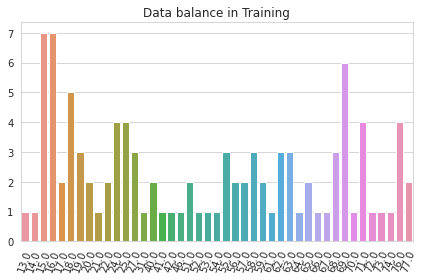

casos_validacao:  12
Média_valores_label_Val:  46.666668
['16.0', '24.0', '26.0', '28.0', '33.0', '37.0', '53.0', '58.0', '64.0', '68.0', '74.0', '79.0']
[1 1 1 1 1 1 1 1 1 1 1 1]
12


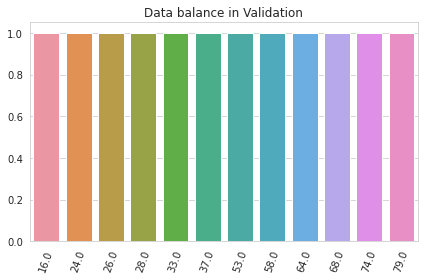

In [15]:
def visualize_holdout_balance():
    _, y_train = next(iter(train_dl_all))
    _, y_val = next(iter(val_dl_all))
    sns.set_style('whitegrid')
    casos_treino=len(y_train) 
    casos_validacao=len(y_val)
    print("casos_treino: ",casos_treino)
    print("Média_valores_label_Train: ", np.mean(y_train.numpy()))
    
    sns.set_style('whitegrid')
    x, y = np.unique(y_train, return_counts=True)
    x=[str(n) for n in x]
    print(x)
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x, y)
    grafico.set_title('Data balance in Training')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 
    
    print("casos_validacao: ",casos_validacao)
    print("Média_valores_label_Val: ", np.mean(y_val.numpy()))
    sns.set_style('whitegrid')
    x, y = np.unique(y_val, return_counts=True)
    x=[str(n) for n in x]
    print(x)
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x, y)
    grafico.set_title('Data balance in Validation')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 
    
visualize_holdout_balance()

## 4. Definir o Modelo

In [16]:
model = FullyConnectedNet(1205, 1, [10, 50, 100, 150, 150, 100, 50, 10], dropout = 0.2)
# visualizar a rede
print(summary(model, input_size=(BATCH_SIZE, 1205), verbose=0)) 
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
FullyConnectedNet                        [1, 1]                    --
├─Flatten: 1-1                           [1, 1205]                 --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 10]                   12,060
│    └─ADN: 2-2                          [1, 10]                   --
│    │    └─Dropout: 3-1                 [1, 10]                   --
│    │    └─PReLU: 3-2                   [1, 10]                   1
├─Sequential: 1-3                        [1, 50]                   --
│    └─Linear: 2-3                       [1, 50]                   550
│    └─ADN: 2-4                          [1, 50]                   --
│    │    └─Dropout: 3-3                 [1, 50]                   --
│    │    └─PReLU: 3-4                   [1, 50]                   1
├─Sequential: 1-4                        [1, 100]                  --
│    └─Linea

FullyConnectedNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden_0): Sequential(
    (0): Linear(in_features=1205, out_features=10, bias=True)
    (1): ADN(
      (D): Dropout(p=0.2, inplace=False)
      (A): PReLU(num_parameters=1)
    )
  )
  (hidden_1): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): ADN(
      (D): Dropout(p=0.2, inplace=False)
      (A): PReLU(num_parameters=1)
    )
  )
  (hidden_2): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ADN(
      (D): Dropout(p=0.2, inplace=False)
      (A): PReLU(num_parameters=1)
    )
  )
  (hidden_3): Sequential(
    (0): Linear(in_features=100, out_features=150, bias=True)
    (1): ADN(
      (D): Dropout(p=0.2, inplace=False)
      (A): PReLU(num_parameters=1)
    )
  )
  (hidden_4): Sequential(
    (0): Linear(in_features=150, out_features=150, bias=True)
    (1): ADN(
      (D): Dropout(p=0.2, inplace=False)
      (A): PReLU(num_parameters=1)
    )
  

## 5. Treinar o Modelo

In [17]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer, scheduler):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {} 
        #Train phase
        model.train() 
        running_loss  = 0.0
        for train_data, labels in train_dl: 
            train_data = train_data.to(device)
            labels = labels.to(device)
            outputs = model(train_data)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * train_data.size(0) 
        epoch_loss = running_loss / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
            
        #Validation phase
        model.eval() 
        running_loss  = 0.0
        for train_data, labels in val_dl: 
            train_data = train_data.to(device)
            labels = labels.to(device)
            outputs = model(train_data)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * train_data.size(0) 
        epoch_loss = running_loss / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        scheduler.step(epoch_loss) 
        epoch_lr = optimizer.param_groups[0]['lr'] 
        logs['val_lr'] = epoch_lr
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file) 

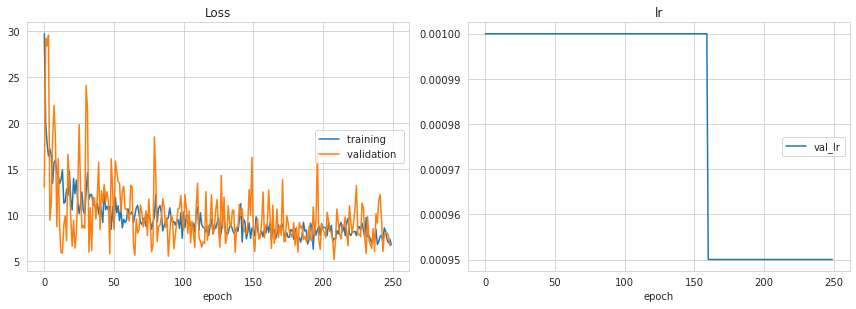

Loss
	training         	 (min:    6.318, max:   29.737, cur:    6.806)
	validation       	 (min:    5.193, max:   29.600, cur:    6.762)
lr
	val_lr           	 (min:    0.001, max:    0.001, cur:    0.001)
Tempo gasto: 440.4406421277672 segundos


In [18]:
#treino do modelo CNNModel_1
EPOCHS = 250
LEARNING_RATE = 0.001
criterion = L1Loss() 
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.95, patience=70)
starttime = time.perf_counter()
train_model('CNNModel_1.pth', train_dl, val_dl, model, criterion, optimizer, scheduler)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## 6. Testar o Modelo

In [19]:
# Avaliar o modelo
def predict(test_dl, model):
    predictions = []
    previsoes = []
    for test_data in test_dl:
        # avaliar o modelo com os casos de teste
        test_data = test_data[0].to(device)
        yprev = model(test_data)
        
        # retirar o array numpy
        yprev = yprev.detach().cpu().numpy()

        # reshape for stacking
        yprev = yprev.reshape((len(yprev), 1))
        
        # guardar
        predictions.append(yprev)

    predictions = np.vstack(predictions)
    
    for i in predictions:
        previsoes.append(i[0])
    previsoes = np.array(previsoes)
    
    return previsoes

# testar o modelo
predictions = predict(test_dl, model)
print("Previsão", predictions)

Previsão [17.624626 63.54057  64.5982   20.02098  18.261444 21.923073 65.77147
 27.004398 23.596228 73.05679  64.61434  66.36532  67.229294 58.69586
 58.98819  64.34296  28.559143 70.82338  63.284344 30.020012 72.43691
 19.675817 64.825874 32.84335  30.802631 57.912945 64.862144 29.716114]


In [20]:
#Guardar os resultados num csv
ids = np.arange(1,29,1)

df = pd.DataFrame({"id" : ids, "age" : predictions})
df.to_csv("submission_todos_dados.csv", index=False)

## 7. Feature Importance

### Feature Permutation

In [21]:
feature_perm = FeaturePermutation(model)
attributions = feature_perm.attribute(train_dados.cuda(), target=0)
attributions = attributions.cpu().detach().numpy()

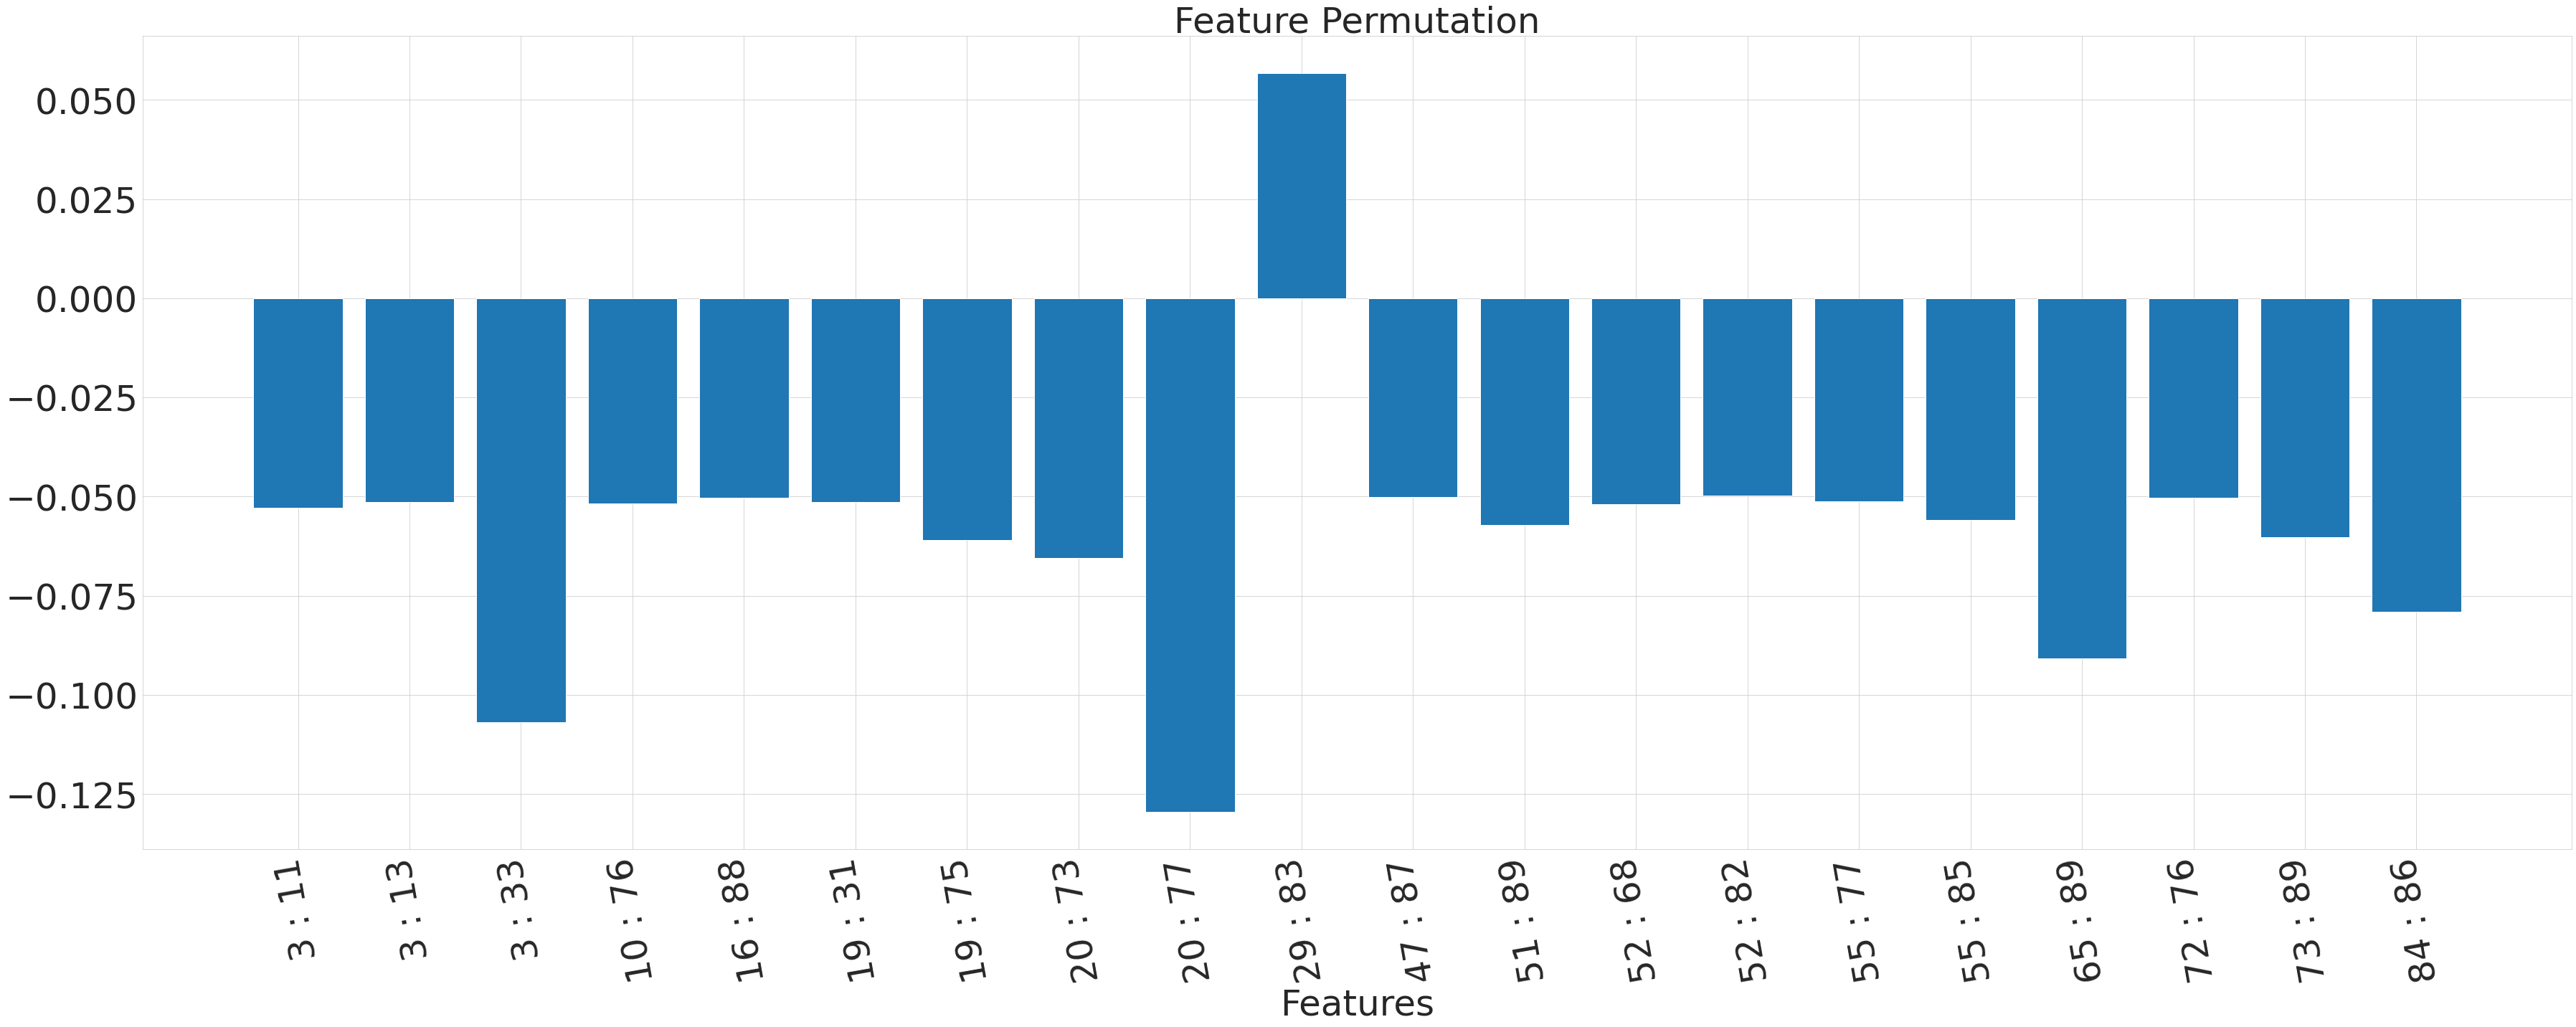

In [22]:
# Helper method to print importances and visualize distribution
feature_names = lista_dic[0].keys()

def visualize_importances(feature_names, importances, title="Feature Permutation", plot=True, axis_title="Features"):
    more_important = []
    important_names = []
    minimo = min(importances)
    maximo = max(importances)
    #print(minimo, maximo)
    
    for i, feature in enumerate(feature_names):
        if abs(importances[i]) > 0.0495:
            more_important.append(importances[i])
            important_names.append(feature)
            
    x_pos = (np.arange(len(important_names)))
    if plot:
        plt.figure(figsize=(50, 20))
        plt.bar(x_pos, more_important)
        plt.xticks(x_pos, important_names, rotation=100)
        plt.xlabel(axis_title, fontsize=50)
        plt.xticks(fontsize=50)
        plt.yticks(fontsize=50)
        plt.title(title, fontsize=50)
        plt.tight_layout()
        plt.show() 
        
visualize_importances(feature_names, np.mean(attributions, axis=0))